In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

import torch
from torch import nn
from torch.utils.data import DataLoader,dataset

In [3]:
from torchvision.transforms import ToTensor,Lambda
from torchvision.datasets import FashionMNIST

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<h3>Downloading and preparing data</h3>

In [5]:
train_set = FashionMNIST(
    root = "datasets",
    download= True,
    train = True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y : torch.zeros(10, dtype = torch.float).scatter_(0,torch.tensor(y),value = 1))
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]


Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 6.56MB/s]

Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 63.4MB/s]


Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.06MB/s]


Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



In [6]:
test_set = FashionMNIST(
    root = "datasets",
    download= True,
    train = False,
    transform=ToTensor(),
    target_transform = Lambda(lambda y : torch.zeros(10, dtype = torch.float).scatter_(0,torch.tensor(y),value = 1))
)

In [7]:
print(train_set.__getitem__(10)[1])
print(test_set.__getitem__(3)[1])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [8]:
def show_sample(set : dataset,inds : list, n : int =  4, predicted : list = None):

    names_dict = set.class_to_idx

    def get_key(dc,target):
        for key in dc.keys():
            if dc[key] == target:
                return key

    fig = plt.figure(figsize = (n,n))
    for i in range(n**2):
        ax = fig.add_subplot(n,n,i+1)
        if i < len(inds):
            img_info = set.__getitem__(inds[i])
            ax.imshow(img_info[0].numpy()[0],cmap = "inferno",alpha = 0.7)
            title = f"{get_key(names_dict,img_info[1].argmax())}"
            if predicted != None and i < len(predicted):
                title += f"\n{get_key(names_dict,predicted[i])}"
            ax.set_title(title)
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    return fig

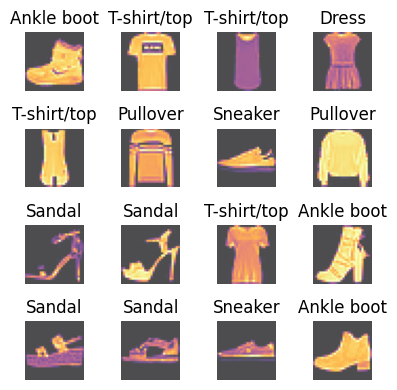

In [9]:
fig = show_sample(train_set,[i for i in range(16)],4)

In [10]:
train_dl = DataLoader(train_set, batch_size = 41, shuffle = True)
test_dl = DataLoader(test_set, batch_size = 16, shuffle=True)

<h3>Preparing model for presentation</h3>

In [34]:
# we have to determine the size of theinput data

_,n,m = train_dl.dataset.__getitem__(0)[0].shape
print(n,m)

labels = train_dl.dataset.class_to_idx
print(labels)
print(len(labels))

28 28
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
10


In [35]:
class DenseNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flattering = nn.Flatten()
        self.DenseLayer = nn.Sequential(
            nn.Linear(n * m , 1514),
            nn.ReLU(),
            nn.Linear(1514,1514),
            nn.ReLU(),
            nn.Linear(1514,1514),
            nn.ReLU(),
            nn.Linear(1514,10)
        )

    def forward(self,x):
        x = self.flattering(x)
        x = self.DenseLayer(x)
        return x

In [40]:
model = DenseNN().to(device)
lr = 1e-3
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [41]:
def training_loop(dataloader,model,loss,optimizer):
    avgd_loss = 0.
    avgd_accuracy = 0.
    batches = len(dataloader)

    for _, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        size = len(X)

        logits = model(X)
        pred = nn.Softmax(dim = 1)(logits)
        loss_val = loss(pred,y)

        loss_val.backward()
        optimizer.step()
        optimizer.zero_grad()

        avgd_loss += loss_val.item()
        with torch.inference_mode():
            avgd_accuracy += (pred.argmax(dim = 1) == y.argmax(dim = 1)).sum() / size

    return avgd_loss / batches, avgd_accuracy / batches


def testing_loop(dataloader,model,loss):
    avgd_loss = 0.
    avgd_accuracy = 0.
    batches = len(dataloader)

    for _, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        with torch.inference_mode():
            size = len(X)

            logits = model(X)
            pred = nn.Softmax(dim = 1)(logits)
            loss_val = loss(pred,y)

            avgd_loss += loss_val.item()
            avgd_accuracy += (pred.argmax(dim = 1) == y.argmax(dim = 1)).sum() / size

    return avgd_loss / batches, avgd_accuracy / batches



In [42]:
epochs = 101

loss_arr_train = []
accuracy_arr_train = []
loss_arr_test = []
accuracy_arr_test = []

for epoch in range(epochs):
    loss_train,acc_train = training_loop(train_dl,model,loss,optimizer)
    loss_test,acc_test = testing_loop(test_dl,model,loss)
    if(epoch % 10 == 0):
      print(f"epoch: {epoch + 1}/{epochs}" + "-" * 10)
      print(f"training set:")
      print(f"accuracy: {acc_train}, loss: {loss_train}")
      print(f"testing set:")
      print(f"accuracy: {acc_test}, loss: {loss_test}")


epoch: 1/101----------
training set:
accuracy: 0.13217107951641083, loss: 2.302263433653149
testing set:
accuracy: 0.15860000252723694, loss: 2.3017771747589113
epoch: 11/101----------
training set:
accuracy: 0.20195700228214264, loss: 2.285572606683429
testing set:
accuracy: 0.2028999924659729, loss: 2.283772647857666
epoch: 21/101----------
training set:
accuracy: 0.3828792870044708, loss: 2.100240861783262
testing set:
accuracy: 0.44859999418258667, loss: 2.0820304622650148
epoch: 31/101----------
training set:
accuracy: 0.6684039831161499, loss: 1.8407435505116572
testing set:
accuracy: 0.665399968624115, loss: 1.8412001922607422
epoch: 41/101----------
training set:
accuracy: 0.7021512389183044, loss: 1.7780812717363483
testing set:
accuracy: 0.6972999572753906, loss: 1.7821072259902955
epoch: 51/101----------
training set:
accuracy: 0.759560227394104, loss: 1.735048393164176
testing set:
accuracy: 0.7538999915122986, loss: 1.739733070755005
epoch: 61/101----------
training set:
a

In [47]:
def predict_and_show(n):
  predicted = []
  for i in range(n ** 2):
    img = test_set.__getitem__(i)[0].to(device)
    val = model(img)
    with torch.inference_mode():
      predicted.append(nn.Softmax(dim = 1)(val).argmax())

  fig = show_sample(test_set,[i for i in range(n ** 2)],n,predicted)
  return fig

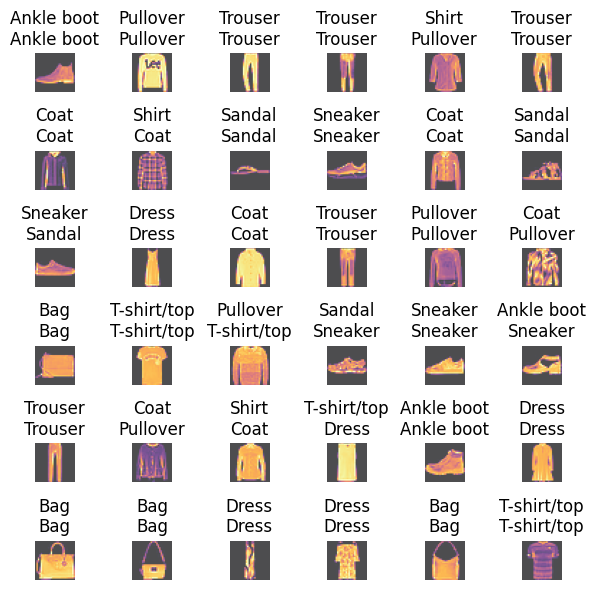

In [49]:
fig = predict_and_show(6)